In [1]:
# Import General Libs
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt 

# Import XG Boost libs
from xgboost import XGBClassifier

# Import Other modeling libs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve,classification_report



In [2]:

def get_heart_data():
    # import data from sqlite3 database
    con = sqlite3.connect('./../../../Database.db')
    df = pd.read_sql_query("SELECT * FROM Heart_disease", con)
    return df

In [3]:
df = get_heart_data()

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   HeartDisease      319795 non-null  object
 1   BMI               319795 non-null  object
 2   Smoking           319795 non-null  object
 3   AlcoholDrinking   319795 non-null  object
 4   Stroke            319795 non-null  object
 5   PhysicalHealth    319795 non-null  object
 6   MentalHealth      319795 non-null  object
 7   DiffWalking       319795 non-null  object
 8   Sex               319795 non-null  object
 9   AgeCategory       319795 non-null  object
 10  Race              319795 non-null  object
 11  Diabetic          319795 non-null  object
 12  PhysicalActivity  319795 non-null  object
 13  GenHealth         319795 non-null  object
 14  SleepTime         319795 non-null  object
 15  Asthma            319795 non-null  object
 16  KidneyDisease     319795 non-null  obj

In [5]:
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.6,Yes,No,No,3.0,30.0,No,,55-59,White,Yes,Yes,,5.0,Yes,No,
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [6]:
num_col = ['BMI','PhysicalHealth', 'MentalHealth','SleepTime']
cat_col = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory',
       'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
pre_col = ['HeartDisease']

In [7]:
for col in cat_col:
    print(df[col].value_counts())
    print("")

Smoking
No     181889
Yes    127673
        10233
Name: count, dtype: int64

AlcoholDrinking
No     298018
Yes     21777
Name: count, dtype: int64

Stroke
No     307726
Yes     12069
Name: count, dtype: int64

DiffWalking
No     266604
Yes     42958
        10233
Name: count, dtype: int64

Sex
Female    159449
Male      144357
           15989
Name: count, dtype: int64

AgeCategory
65-69          34151
60-64          33686
70-74          31065
55-59          29757
50-54          25382
80 or older    24153
45-49          21791
75-79          21482
18-24          21064
40-44          21006
35-39          20550
30-34          18753
25-29          16955
Name: count, dtype: int64

Race
White                             245212
Hispanic                           27446
Black                              22939
Other                              10928
Asian                               8068
American Indian/Alaskan Native      5202
Name: count, dtype: int64

Diabetic
No                         2

In [8]:
def convert_num_col(df, num_col):
    for col in num_col:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def map_cat_col(df):
    map_sex = {'Female': 0, 'Male': 1}
    map_yn = {'No': 0, 'Yes': 1}
    df['HeartDisease'] = df['HeartDisease'].map(map_yn)
    df['Smoking'] = df['Smoking'].map(map_yn)
    df['AlcoholDrinking'] = df['AlcoholDrinking'].map(map_yn)
    df['Stroke'] = df['Stroke'].map(map_yn)
    df['DiffWalking'] = df['DiffWalking'].map(map_yn)
    df['Sex'] = df['Sex'].map(map_sex)
    df['PhysicalActivity'] = df['PhysicalActivity'].map(map_yn)
    df['Asthma'] = df['Asthma'].map(map_yn)
    df['KidneyDisease'] = df['KidneyDisease'].map(map_yn)
    df['SkinCancer'] = df['SkinCancer'].map(map_yn)
    return df

def replace_missing_data(df):
    df['Smoking'] = df['Smoking'].fillna(0)
    df['DiffWalking'] = df['DiffWalking'].fillna(0)
    df['Sex'] = df['Sex'].fillna(1)
    df['Asthma'] = df['Asthma'].fillna(0)
    df['SkinCancer'] = df['SkinCancer'].fillna(0)
    df['Diabetic'] = df['Diabetic'].fillna(0)
    df['GenHealth'] = df['GenHealth'].replace('','Very good')
    df['BMI'] = df['BMI'].fillna(df['BMI'].median())
    df['PhysicalHealth'] = df['PhysicalHealth'].fillna(df['PhysicalHealth'].median())
    return df

def get_dummies(df):
    col_dumm = ['AgeCategory', 'Race', 'Diabetic', 'GenHealth' ]
    df = pd.get_dummies(df, columns =col_dumm, drop_first= False)
    return df

In [9]:
df = convert_num_col(df, num_col=num_col)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               305085 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    305085 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [11]:
df = map_cat_col(df)


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               305085 non-null  float64
 2   Smoking           309562 non-null  float64
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    305085 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       309562 non-null  float64
 8   Sex               303806 non-null  float64
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            309562 non-null  float64
 16  KidneyDisease     31

In [13]:
df = replace_missing_data(df)


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  int64  
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  float64
 3   AlcoholDrinking   319795 non-null  int64  
 4   Stroke            319795 non-null  int64  
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  float64
 8   Sex               319795 non-null  float64
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  int64  
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  float64
 16  KidneyDisease     31

In [15]:
df = get_dummies(df)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 43 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   HeartDisease                         319795 non-null  int64  
 1   BMI                                  319795 non-null  float64
 2   Smoking                              319795 non-null  float64
 3   AlcoholDrinking                      319795 non-null  int64  
 4   Stroke                               319795 non-null  int64  
 5   PhysicalHealth                       319795 non-null  float64
 6   MentalHealth                         319795 non-null  float64
 7   DiffWalking                          319795 non-null  float64
 8   Sex                                  319795 non-null  float64
 9   PhysicalActivity                     319795 non-null  int64  
 10  SleepTime                            319795 non-null  float64
 11  Asthma       

In [17]:
df.HeartDisease.value_counts()

HeartDisease
0    292422
1     27373
Name: count, dtype: int64

# Split Test and Train Data

In [18]:
def train_test_split_and_features(data):
    y = data['HeartDisease']
    x = data.drop('HeartDisease',axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, shuffle = False, random_state = 0)
    # print(x.head(5))
    print(x.columns)
    features = list(x.columns)
    return x_train, x_test, y_train, y_test,features

In [19]:
x_train, x_test, y_train, y_test,features = train_test_split_and_features(df)

Index(['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', 'PhysicalHealth',
       'MentalHealth', 'DiffWalking', 'Sex', 'PhysicalActivity', 'SleepTime',
       'Asthma', 'KidneyDisease', 'SkinCancer', 'AgeCategory_18-24',
       'AgeCategory_25-29', 'AgeCategory_30-34', 'AgeCategory_35-39',
       'AgeCategory_40-44', 'AgeCategory_45-49', 'AgeCategory_50-54',
       'AgeCategory_55-59', 'AgeCategory_60-64', 'AgeCategory_65-69',
       'AgeCategory_70-74', 'AgeCategory_75-79', 'AgeCategory_80 or older',
       'Race_American Indian/Alaskan Native', 'Race_Asian', 'Race_Black',
       'Race_Hispanic', 'Race_Other', 'Race_White', 'Diabetic_', 'Diabetic_No',
       'Diabetic_No, borderline diabetes', 'Diabetic_Yes',
       'Diabetic_Yes (during pregnancy)', 'GenHealth_Excellent',
       'GenHealth_Fair', 'GenHealth_Good', 'GenHealth_Poor',
       'GenHealth_Very good'],
      dtype='object')


# Try Decission Tree

In [ ]:
# Decission Tree Libs
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

In [155]:
dtree = DecisionTreeClassifier(max_depth=3,min_samples_split=10)

In [156]:
def fit_and_evaluate_model(x_train, x_test, y_train, y_test,dtree):
    dtree.fit(x_train, y_train)
    dtre_predict = dtree.predict(x_test)
    dtre_conf_matrix = confusion_matrix(y_test, dtre_predict)
    dtre_acc_score = accuracy_score(y_test, dtre_predict)
    print("confussion matrix")
    print(dtre_conf_matrix)
    print("\n")
    print("Accuracy of XGBoost:",dtre_acc_score*100,'\n')
    print(classification_report(y_test,dtre_predict))
    return dtree

In [164]:
dtree = DecisionTreeClassifier(max_depth=100,min_samples_split=10, class_weight={0:1,1:150})
model = fit_and_evaluate_model(x_train, x_test, y_train, y_test,dtree)

#confussion matrix
# [[58457   114]
#  [ 5218   170]]

confussion matrix
[[50467  8104]
 [ 3384  2004]]


Accuracy of XGBoost: 82.03849340984067 

              precision    recall  f1-score   support

           0       0.94      0.86      0.90     58571
           1       0.20      0.37      0.26      5388

    accuracy                           0.82     63959
   macro avg       0.57      0.62      0.58     63959
weighted avg       0.87      0.82      0.84     63959



# Try Random Forest

In [144]:
# Normalization for Random Forest


,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,PhysicalActivity,...,Diabetic_,Diabetic_No,"Diabetic_No, borderline diabetes",Diabetic_Yes,Diabetic_Yes (during pregnancy),GenHealth_Excellent,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good
0,0,16.60,1.0,0,0,3.0,30.0,0.0,1.0,1,...,False,False,False,True,False,False,False,False,False,True
1,0,20.34,0.0,0,1,0.0,0.0,0.0,0.0,1,...,False,True,False,False,False,False,False,False,False,True
2,0,26.58,1.0,0,0,20.0,30.0,0.0,1.0,1,...,False,False,False,True,False,False,True,False,False,False
3,0,24.21,0.0,0,0,0.0,0.0,0.0,0.0,0,...,False,True,False,False,False,False,False,True,False,False
4,0,23.71,0.0,0,0,28.0,0.0,1.0,0.0,1,...,False,True,False,False,False,False,False,False,False,True


In [36]:
from sklearn.ensemble import RandomForestClassifier


In [37]:
# n_estimators = 100 by default  ( you can try with different values)
# bootstrap ( data row bagging) is True by default
# max_samples = 1

def fit_and_evaluate_model(x_train, x_test, y_train, y_test,max_depth=5,min_samples_split=0.01,max_features=0.8,max_samples=0.8):
    random_forest =  RandomForestClassifier(random_state=0,\
                                            max_depth=max_depth,\
                                            min_samples_split=min_samples_split,\
                                            max_features=max_features,\
                                            max_samples=max_samples,\
                                            class_weight={0:1,1:2}, )

    model = random_forest.fit(x_train, y_train)
    random_forest_predict = random_forest.predict(x_test)
    random_forest_conf_matrix = confusion_matrix(y_test, random_forest_predict)
    random_forest_acc_score = accuracy_score(y_test, random_forest_predict)
    print("confussion matrix")
    print(random_forest_conf_matrix)
    print("\n")
    print("Accuracy of Random Forest:",random_forest_acc_score*100,'\n')
    print(classification_report(y_test,random_forest_predict))
    return model

In [38]:
model = fit_and_evaluate_model(x_train, x_test, y_train, y_test) # 10 weight

confussion matrix
[[57589   982]
 [ 4610   778]]


Accuracy of Random Forest: 91.25689895089042 

              precision    recall  f1-score   support

           0       0.93      0.98      0.95     58571
           1       0.44      0.14      0.22      5388

    accuracy                           0.91     63959
   macro avg       0.68      0.56      0.59     63959
weighted avg       0.89      0.91      0.89     63959



In [39]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
# Use this on your x_train and y_train

# Define the percentage of oversampling 
sampling_strategy = 0.9  # number between 0 to 1 
# after resampling minority class would be 50% of majority class

# Apply SMOTE with specified oversampling percentage
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
x_res, y_res = smote.fit_resample(x_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 233851, 1: 210465})


In [40]:
model = fit_and_evaluate_model(x_res, x_test, y_res, y_test) # 10 weight and 0.4 SMOTE

confussion matrix
[[40508 18063]
 [ 1602  3786]]


Accuracy of Random Forest: 69.25374067762161 

              precision    recall  f1-score   support

           0       0.96      0.69      0.80     58571
           1       0.17      0.70      0.28      5388

    accuracy                           0.69     63959
   macro avg       0.57      0.70      0.54     63959
weighted avg       0.90      0.69      0.76     63959



In [148]:
model = fit_and_evaluate_model(x_res, x_test, y_res, y_test) # 2 weight and 0.5 SMOTE

confussion matrix
[[51226  7345]
 [ 2865  2523]]


Accuracy of Random Forest: 84.03664847793118 

              precision    recall  f1-score   support

           0       0.95      0.87      0.91     58571
           1       0.26      0.47      0.33      5388

    accuracy                           0.84     63959
   macro avg       0.60      0.67      0.62     63959
weighted avg       0.89      0.84      0.86     63959



# Try KNN

In [132]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, mean_squared_error , r2_score
from sklearn import neighbors
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

In [149]:
knn = KNeighborsClassifier(n_neighbors=15)#, weights='distance')
knn.fit(x_train,y_train)
knn.score(x_test,y_test)

0.9151174971466095

In [150]:
y_pre = knn.predict(x_test)
cm = confusion_matrix(y_test, y_pre)
cm

#Initial CM with no modification
# array([[58186,   385],
    #    [ 5144,   244]])

array([[58409,   162],
       [ 5267,   121]])

# XGBoost

In [20]:
# Import XG Boost libs
from xgboost import XGBClassifier

In [21]:
def fit_and_evaluate_model(x_train, x_test, y_train, y_test,xgb):
    xgb.fit(x_train, y_train)
    xgb_predict = xgb.predict(x_test)
    xgb_conf_matrix = confusion_matrix(y_test, xgb_predict)
    xgb_acc_score = accuracy_score(y_test, xgb_predict)
    print("confussion matrix")
    print(xgb_conf_matrix)
    print("\n")
    print("Accuracy of XGBoost:",xgb_acc_score*100,'\n')
    print(classification_report(y_test,xgb_predict))
    return xgb

In [28]:
#Default parameters:
   # learning_rate = 0.3
   # max_depth = 6
   # subsample = 1
   # colsample_bytree = 1
   # n_estimators = 100
xgb =  XGBClassifier(random_state=0)
model = fit_and_evaluate_model(x_train, x_test, y_train, y_test,xgb)

confussion matrix
[[58091   480]
 [ 4849   539]]


Accuracy of XGBoost: 91.66809987648338 

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     58571
           1       0.53      0.10      0.17      5388

    accuracy                           0.92     63959
   macro avg       0.73      0.55      0.56     63959
weighted avg       0.89      0.92      0.89     63959



In [22]:
#Handling Imbalance Data

from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from collections import Counter
# Use this on your x_train and y_train

# Define the percentage of oversampling 
sampling_strategy = 0.9  # number between 0 to 1 
# after resampling minority class would be 50% of majority class

# Apply SMOTE with specified oversampling percentage
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
x_res, y_res = smote.fit_resample(x_train, y_train)

print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0: 233851, 1: 210465})


In [30]:
#Default parameters:
   # learning_rate = 0.3
   # max_depth = 6
   # subsample = 1
   # colsample_bytree = 1
   # n_estimators = 100
xgb =  XGBClassifier(random_state=0)
model = fit_and_evaluate_model(x_res, x_test, y_res, y_test,xgb)

confussion matrix
[[56778  1793]
 [ 4377  1011]]


Accuracy of XGBoost: 90.35319501555684 

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     58571
           1       0.36      0.19      0.25      5388

    accuracy                           0.90     63959
   macro avg       0.64      0.58      0.60     63959
weighted avg       0.88      0.90      0.89     63959



In [23]:
#Default parameters:
   # learning_rate = 0.3
   # max_depth = 6
   # subsample = 1
   # colsample_bytree = 1
   # n_estimators = 100

param_grid = [{'learning_rate': [0.1, 0.3, 0.5, 0.7],
               'max_depth': [3,6,10],
               'subsample': [0.8, 1],
               'colsample_bytree': [0.8, 1],
               'n_estimators' : [50, 100, 150]}
             ]

In [24]:
from sklearn.model_selection import GridSearchCV
model = XGBClassifier(random_state=0, device='mps')
search = GridSearchCV(estimator = model, param_grid = param_grid, cv=5, refit=True, verbose=5)
search.fit(x_res, y_res)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=nan total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=nan total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=nan total time=   0.7s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=nan total time=   0.7s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=0.8;, score=nan total time=   0.7s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1;, score=nan total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=50, subsample=1;, score=nan total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, lea

Exception ignored on calling ctypes callback function: <bound method DataIter._next_wrapper of <xgboost.data.SingleBatchInternalIter object at 0x2a027b850>>
Traceback (most recent call last):
  File "/Users/puneetkucheria/miniconda3/envs/data_science_course/lib/python3.8/site-packages/xgboost/core.py", line 589, in _next_wrapper
    def _next_wrapper(self, this: None) -> int:  # pylint: disable=unused-argument
KeyboardInterrupt: 


[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=nan total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=nan total time=   0.7s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=nan total time=   0.7s
[CV 5/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=0.8;, score=nan total time=   0.7s
[CV 1/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=nan total time=   0.7s
[CV 2/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=nan total time=   0.7s
[CV 3/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1;, score=nan total time=   0.7s
[CV 4/5] END colsample_bytree=0.8, learning_rate=0.1, max_depth=6, n_estimators=100, subsample=1

In [33]:
search.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 10,
 'n_estimators': 150,
 'subsample': 0.8}

In [34]:
xgb = search.best_estimator_
# this is just to show the possibility
# but it is recommended to train the model on complete training dataset again
xgb_predict = xgb.predict(x_test)
xgb_conf_matrix = confusion_matrix(y_test, xgb_predict)
xgb_acc_score = accuracy_score(y_test, xgb_predict)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of XGBoost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predict))

confussion matrix
[[56481  2090]
 [ 4371  1017]]


Accuracy of XGBoost: 89.89821604465361 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     58571
           1       0.33      0.19      0.24      5388

    accuracy                           0.90     63959
   macro avg       0.63      0.58      0.59     63959
weighted avg       0.88      0.90      0.89     63959



# Step 6: Precison Recall analysis

In [35]:
from sklearn.metrics import precision_recall_curve
xgb_predict = xgb.predict(x_test)
xgb_proba = xgb.predict_proba(x_test)
print(xgb_proba[0:10])
print(xgb_predict)

[[0.8804034  0.11959659]
 [0.9883191  0.01168092]
 [0.9982419  0.00175812]
 [0.99664575 0.00335424]
 [0.9594616  0.04053835]
 [0.9689969  0.03100309]
 [0.9981729  0.00182713]
 [0.9550784  0.04492155]
 [0.98784065 0.01215935]
 [0.9408665  0.05913353]]
[0 0 0 ... 0 0 0]


In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, xgb_proba[:,1])

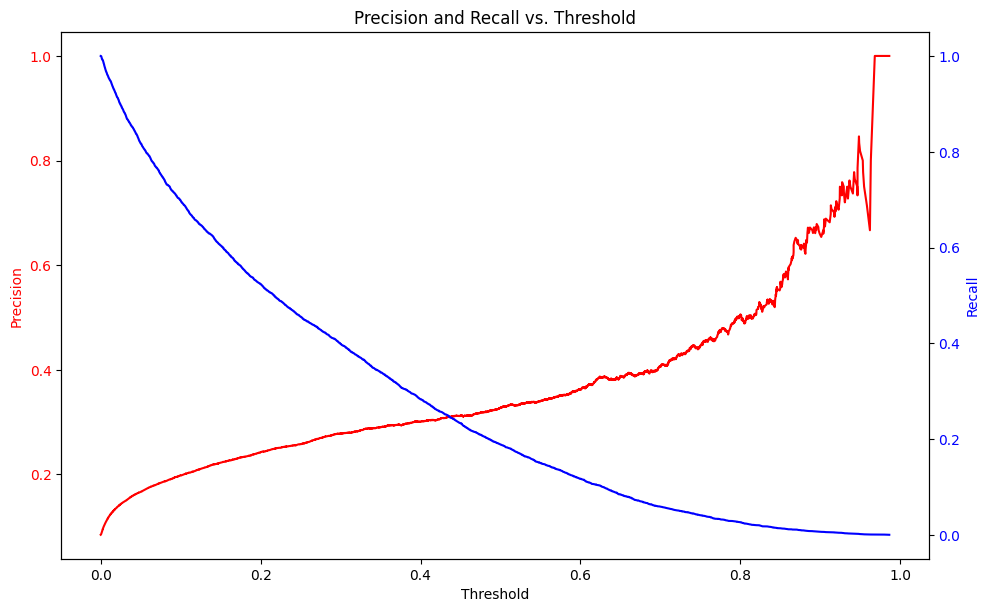

In [37]:
import numpy as np
# Plot precision and recall on separate y-axes
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision', color='red')
ax1.plot(thresholds, precision[:-1], color='red', label='Precision')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.set_ylabel('Recall', color='blue')
ax2.plot(thresholds, recall[:-1], color='blue', label='Recall')
ax2.tick_params(axis='y', labelcolor='blue')


fig.tight_layout()
plt.title('Precision and Recall vs. Threshold')
plt.show()

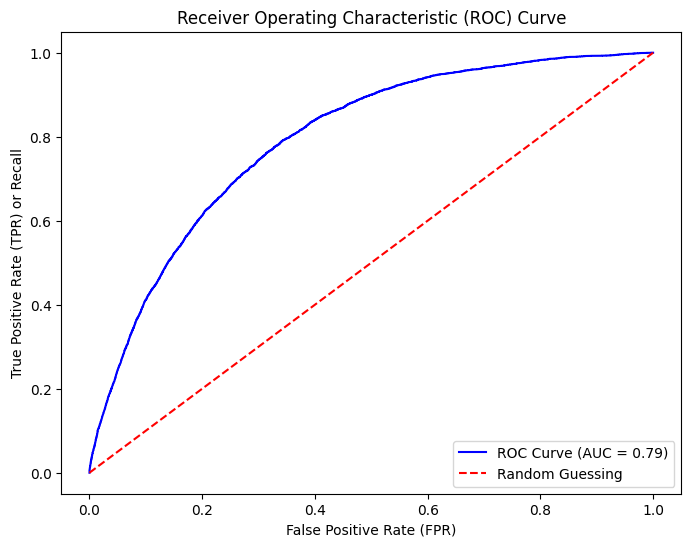

In [38]:
# applicable for any binary classfication model 

#FPR = FP / (FP + TN)
#It measures the proportion of actual negative instances that are incorrectly predicted as positive.

#TPR = TP / (TP + FN)
#It measures the proportion of actual positive instances that are correctly predicted as positive.

from sklearn.metrics import roc_curve, auc


# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, xgb_proba[:,1])

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guessing')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [39]:
# Default results

xgb_conf_matrix = confusion_matrix(y_test, xgb_predict)
xgb_acc_score = accuracy_score(y_test, xgb_predict)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of XGBoost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,xgb_predict))

confussion matrix
[[56481  2090]
 [ 4371  1017]]


Accuracy of XGBoost: 89.89821604465361 

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     58571
           1       0.33      0.19      0.24      5388

    accuracy                           0.90     63959
   macro avg       0.63      0.58      0.59     63959
weighted avg       0.88      0.90      0.89     63959



In [1]:
# Results with new threshold

custom_threshold = .5

# Apply the custom threshold to obtain binary predictions
custom_predictions = (xgb_proba[:,1] > custom_threshold).astype(int)
print(xgb_proba[:,1])
print(custom_predictions)

NameError: name 'xgb_proba' is not defined

In [2]:
#Precision = TP / (TP + FP)
#Precision indicates the proportion of positive predictions that were actually correct.

#Recall = TP / (TP + FN)
#Recall indicates the proportion of actual positive instances that were correctly identified by the model.

xgb_conf_matrix = confusion_matrix(y_test, custom_predictions)
xgb_acc_score = accuracy_score(y_test, custom_predictions)
print("confussion matrix")
print(xgb_conf_matrix)
print("\n")
print("Accuracy of XGBoost:",xgb_acc_score*100,'\n')
print(classification_report(y_test,custom_predictions))

NameError: name 'confusion_matrix' is not defined